A complete dataset of socio-demographic data per ZIPCODE (UHFs) of New York city had been built using different sources as nyc.gov Open Data, data of New York city, 5 years survay of Census Bureau, NYC Health department website for the data referring to Covid-19 testing and ; for this purpose the avaiable code related to the paper "Assessing capacity to social distance and neighborhood-level health disparities during the COVID-19 pandemic" (doi: https://doi.org/10.1101/2020.06.02.20120790) has been used.

In our cases, NYC Health department data are updated at the 1st October, before the second round of infections.
Positive cases per zipcode refers to the number of people in that census tract that had result positive to the antibody test: this type of test can find out if someone has ever had the virus.

Here is presented an analysis of the data.

In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [72]:
data_per_zcta = pd.read_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/Complete_data_per_zipcodes.csv")

x_shapes = gpd.read_file("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/shapes/shapes.shp")
x_shapes['zcta']=pd.to_numeric(x_shapes['zcta'])

complete_data_per_zcta = x_shapes.merge(data_per_zcta, on='zcta')

In [73]:
complete_data_per_zcta.rename(columns={'Positive': 'Positive cases'}, inplace=True)
complete_data_per_zcta.rename(columns={'Total': 'Total tests'}, inplace=True)
complete_data_per_zcta.rename(columns={'modzcta_cum_perc_pos': 'Perc Positive'}, inplace=True)
complete_data_per_zcta.rename(columns={'total_commute1': 'Tot commuters'}, inplace=True)
complete_data_per_zcta.rename(columns={'not_insured': 'Perc of not insured'}, inplace=True)

data_per_zcta.rename(columns={'Positive': 'Positive cases'}, inplace=True)
data_per_zcta.rename(columns={'Total': 'Total tests'}, inplace=True)
data_per_zcta.rename(columns={'modzcta_cum_perc_pos': 'Perc Positive'}, inplace=True)
data_per_zcta.rename(columns={'total_commute1': 'Tot commuters'}, inplace=True)
data_per_zcta.rename(columns={'not_insured': 'Perc of not insured'}, inplace=True)
#not_quarantined_jobs refers to an estimates of workers still moving to go to workplace

data_per_zcta.drop(['zcta', 'median_rent', 'valid_var','total_res_volume_zcta'], axis='columns', inplace=True)

Using as reference the study on the different socio-demographiv and economic variables at zcta-level related to the social disadvantage, we focus on the variables that are more correlated to the number of positive cases (as index of infection at ZCTA-level) and then we would like to do a Multiple Linear Regression on these significative variables to predict the outcome variable value on which we can focus: positive cases per ZCTA.

We use at first Pearson’s Correlation Coefficient: it is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

In our case, we've chosen to focus on medium-high level of correlation with the number of positive cases, in a range [$\pm$ 0.45:$\pm$ 1], obviously getting rid of variables obviously related to this number such as: percentage of positives, positives per 100k persons, total number of workers, population and households, number of total tests in each zcta.

I won't consider variables such as SNAP households (means portion of households that rely on Supplemental nutrition Assistance program) or flp_150, indicating the portion of population below 150% of Federal poverty level are strongly correlated to median income values.

As in article "Assessing capacity to social distance and neighborhood-level health disparities during the COVID-19 pandemic", it would be reasonable to try to include in a unique index these variables.

In [74]:
corr_matrix = data_per_zcta.corr() #Using Pearson's coefficient
type(corr_matrix)

corr_matrix.to_csv("/home/claudia/Scrivania/Tesi NYC pandemic /COVID_19_data_Rstudio/corr_matrix1.csv")

#inserire immagine jpg da excel o table or heathmap without numbers

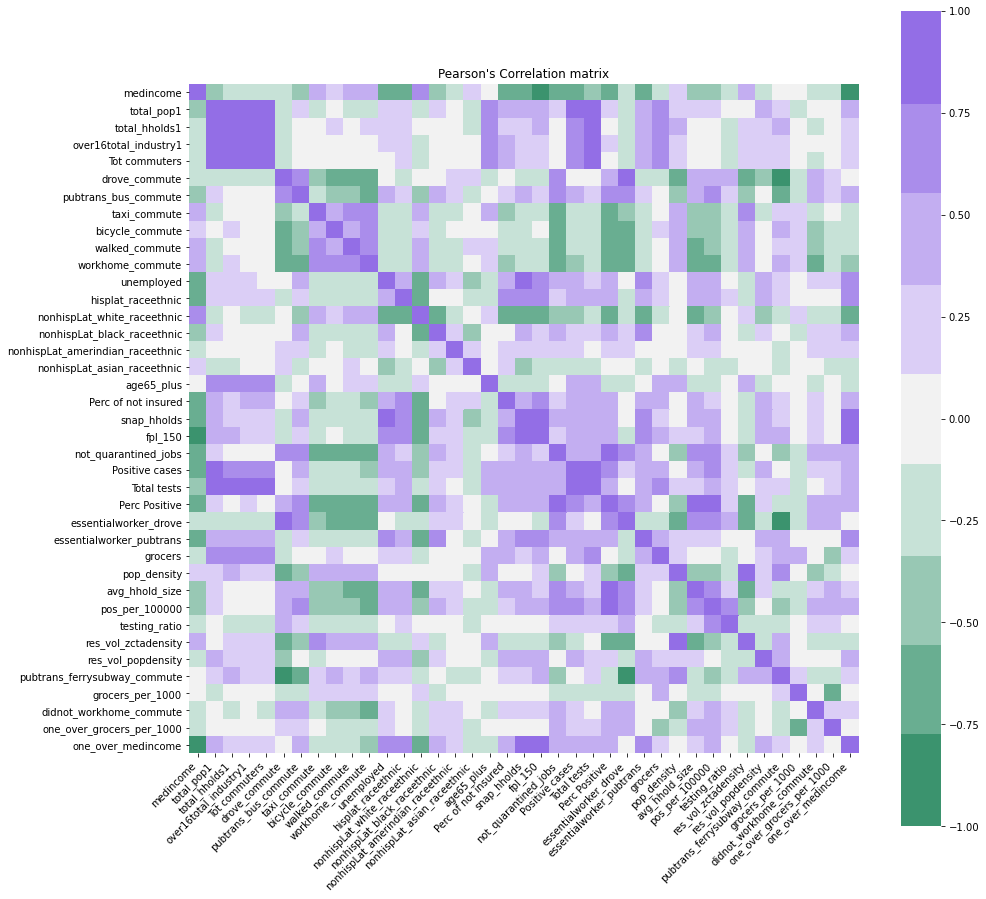

In [85]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title("Pearson's Correlation matrix");

In [93]:
print(corr_matrix['Positive cases']) #can be insert as a jpg file 
#corr_matrix

medincome                          -0.555823
total_pop1                          0.845194
total_hholds1                       0.672714
over16total_industry1               0.733922
Tot commuters                       0.727285
drove_commute                       0.060135
pubtrans_bus_commute                0.367615
taxi_commute                       -0.290707
bicycle_commute                    -0.276682
walked_commute                     -0.273520
workhome_commute                   -0.390306
unemployed                          0.377390
hisplat_raceethnic                  0.448620
nonhispLat_white_raceethnic        -0.468141
nonhispLat_black_raceethnic         0.266035
nonhispLat_amerindian_raceethnic    0.137950
nonhispLat_asian_raceethnic        -0.173085
age65_plus                          0.345729
Perc of not insured                 0.484701
snap_hholds                         0.529130
fpl_150                             0.511245
not_quarantined_jobs                0.497094
Positive c

### Construction of an "Infection Index"

The choice of variables that most reppresent an indicator of social disadvantage related to the incidence of Covid-19, looking at the Pearson's correlation coefficient, are:

- total number of commuters (+0.73);
- percentage of workers commuting using public transports (+0.53);
- percentage of not covered by healt insurance (+0.48)
- one over median income (+0.49) [using the idea of the reciprocal as in the paper]

In [ ]:
data_per_boro = data_per_zcta.groupby(["Borough"]).mean()

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
complete_data_per_zcta.plot(column='total_pop1', cmap='PuBu', ax=ax, figsize=(8,8), edgecolor='b', legend=True, legend_kwds={'label': "Covid_19 Cases Rate per 100k",'orientation': "vertical"})
plt.grid()